# LIME

In this notebook, we'll use LIME to generate explanations via saliency maps for an Inception model in Tensorflow.

Let's use the LIME library, so let's start by installing `lime` in case it isn't already.

In [1]:
# !pip install lime==0.2.0.1

In [2]:
import tensorflow as tf
import numpy as np
import PIL.Image
from skimage.io import imread
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

from lime import lime_image

%matplotlib inline

2022-08-22 02:59:33.340227: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [3]:
print(f'Tensorflow verseion: {tf.__version__}')

Tensorflow verseion: 2.3.4


### Utility methods from the saliency example notebook

In [4]:
def LoadImage(file_path, model='VGG'):
    im = PIL.Image.open(file_path)
    if model == 'Inception':
        im = im.resize((299,299))
    else: 
        im = im.resize((224,224))
    im = np.asarray(im)
    return im

def PreprocessVGGImage(im):
    im = tf.keras.applications.vgg16.preprocess_input(im)
    return im

def PreprocessInceptionImage(im):
    im = tf.keras.applications.inception_v3.preprocess_input(im)
    return im

## Examine superpixels

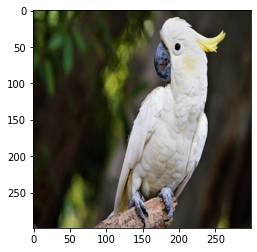

In [5]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg', model='Inception')

plt.imshow(im_orig)
plt.show()

LIME works by creating superpixels from an image. Let's see what superpixels are creating using different segmentation algorithms. 

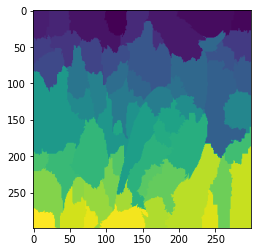

In [6]:
from skimage.segmentation import felzenszwalb, quickshift

segments = quickshift(im_orig,
                      kernel_size=4,
                      max_dist=200,
                      ratio=0.2,
                      random_seed=42)
plt.imshow(segments)
plt.show()

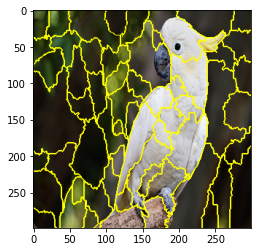

In [7]:
plt.imshow(mark_boundaries(im_orig, segments))
plt.show()

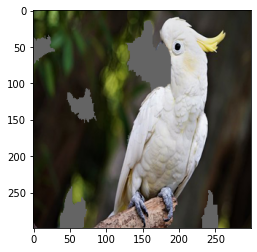

In [8]:
segmented_image = im_orig.copy()

# Isolate a few segments
segmented_image[segments == 11] = 100
segmented_image[segments == 28] = 100
segmented_image[segments == 16] = 100
segmented_image[segments == 55] = 100
segmented_image[segments == 56] = 100
plt.imshow(segmented_image)
plt.show()

Choosing different segments, creates differet superpixels:

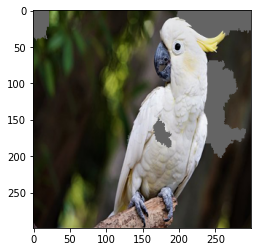

In [9]:
fudged_image = im_orig.copy()
# Isolate a few segments
fudged_image[segments == 1] = 100
fudged_image[segments == 2] = 100
fudged_image[segments == 18] = 100
fudged_image[segments == 5] = 100
fudged_image[segments == 36] = 100
plt.imshow(fudged_image)
plt.show()

You can create a superpixel by replacing with the average of its pixels.



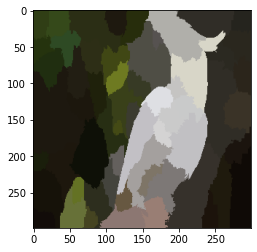

In [11]:
segmented_image = im_orig.copy()
# Replace superpixel with average of the pixel values
for x in np.unique(segments):
    segmented_image[segments == x] = (
        np.mean(im_orig[segments == x][:, 0]),
        np.mean(im_orig[segments == x][:, 1]),
        np.mean(im_orig[segments == x][:, 2]))
    
plt.imshow(segmented_image)
plt.show()

#### Using Felzenszwalb's algorithm

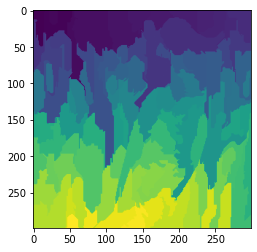

In [12]:
segments = felzenszwalb(im_orig, min_size=200)
plt.imshow(segments)
plt.show()

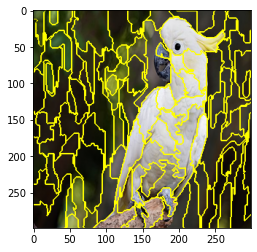

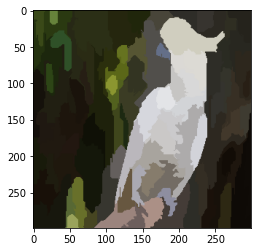

In [13]:
plt.imshow(mark_boundaries(im_orig, segments))
plt.show()
segmented_image = im_orig.copy()
for x in np.unique(segments):
    segmented_image[segments == x] = (
        np.mean(im_orig[segments == x][:, 0]),
        np.mean(im_orig[segments == x][:, 1]),
        np.mean(im_orig[segments == x][:, 2]))
plt.imshow(segmented_image)
plt.show()

## Explain predictions using LIME

### Load the model

We'll use a pretrained Inception model available in Keras. 

In [14]:
inception = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet')
model = tf.keras.models.Model(inception.inputs, inception.output)

2022-08-22 03:00:13.212739: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-22 03:00:15.612060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 03:00:15.614777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-08-22 03:00:15.614867: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-08-22 03:00:15.641197: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-08-22 03:00:15.655854: I tensorflow/stream_executor/platform/default/d

2022-08-22 03:00:23.341755: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8
2022-08-22 03:00:33.181067: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


Prediction class: 89


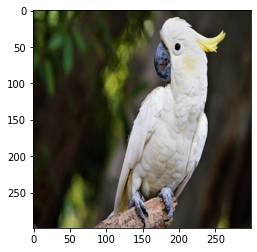

In [15]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg', model='Inception')
image = PreprocessInceptionImage(im_orig)

# Show the image
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class)) 

We'll use the `LimeImageExplainer` to generate explanations using LIME.

In [16]:
explainer = lime_image.LimeImageExplainer()

# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image=image.astype('double'),
                                         classifier_fn=inception.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


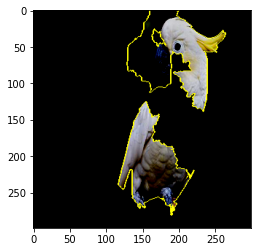

In [17]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=6,
                                            hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

To get an overlay of the superpixels with positive influence, we change the arguments `positive_only` and `hide_rest`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


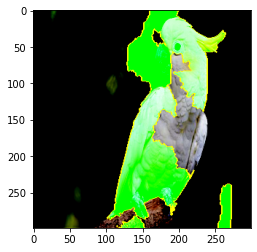

In [18]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

To see an overaly with negative attributed superpixels, change the argument `positive_only=False`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


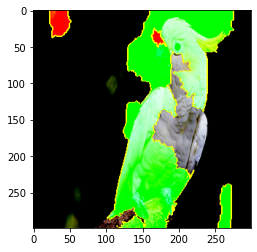

In [19]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=False,
                                            num_features=15,
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

#### Compare with the explanations for the second highest prediction

Here the second highest prediction corresponds to 'spoonbill'

In [20]:
explanation.top_labels[1]      # 129 indicates spoonbill

129

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


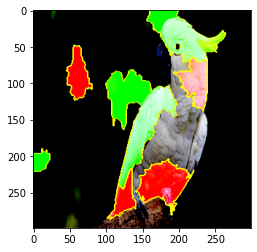

In [21]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[1],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

This still gives some explanations, but if we cut off the `min_weight`, then we see no relevant pixels.
Here we look at next highest prediction, but set `min_weight = 0.1`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


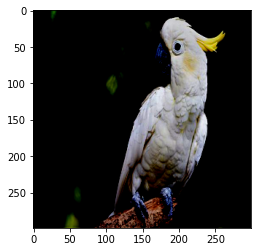

In [22]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[1],
                                            positive_only=False, 
                                            num_features=100,
                                            hide_rest=False,
                                            min_weight=0.1)
plt.imshow(mark_boundaries(temp, mask))
plt.show()

#### Another example
Let's look at anohter example, this time a goldfinch.

Prediction class: 11


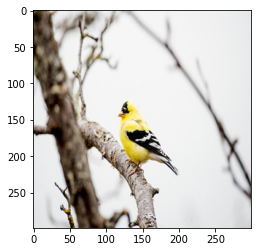

In [23]:
# Load the image
im_orig = LoadImage('./images/goldfinch.jpeg', model='Inception')
image = PreprocessInceptionImage(im_orig)

# Show the image
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))       # 11 corresponds to golfinch

In [24]:
explainer = lime_image.LimeImageExplainer()

# Hide color is the color for a superpixel turned OFF.
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image=image.astype('double'),
                                         classifier_fn=inception.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


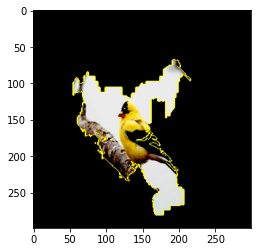

In [25]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5,
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp, mask))
plt.show()

### Using VGG-16 model

So far, we've been using an Inception model. Let's see how the explanations change using a VGG-16 model.

In [26]:
vgg16 = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', include_top=True)
model = tf.keras.models.Model(vgg16.inputs, vgg16.output)

Prediction class: 89


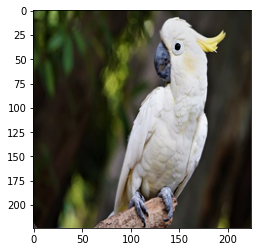

In [27]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg', model='VGG')
image = PreprocessVGGImage(im_orig)

# Show the image
# ShowImage(im_orig)
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))  

In [28]:
explainer = lime_image.LimeImageExplainer()

In [29]:
explanation = explainer.explain_instance(image=image.astype('double'),
                                         classifier_fn=vgg16.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


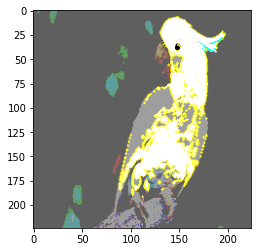

In [31]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5,
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.imshow(image, alpha=0.25)
plt.show()

### View pros and cons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


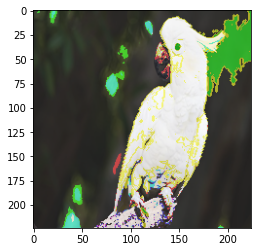

In [32]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False)

plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)
plt.show()

Prediction class: 88


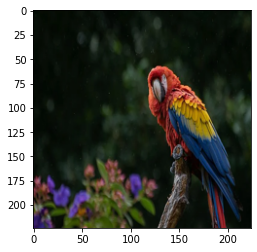

In [38]:
# Load the image
im_orig = LoadImage('./images/macaw.jpeg', model='VGG')
image = PreprocessVGGImage(im_orig)

# Show the image
plt.imshow(im_orig)

predictions = model(np.array([image]))
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))    # class 88: macaw  

In [39]:
explainer = lime_image.LimeImageExplainer()

In [41]:
explanation = explainer.explain_instance(image=image.astype('double'),
                                         classifier_fn=vgg16.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


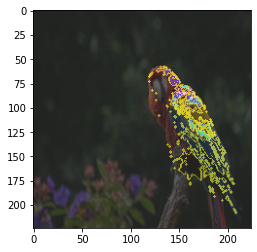

In [42]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5,
                                            hide_rest=True)

plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(temp, mask), alpha=0.5)
plt.show()

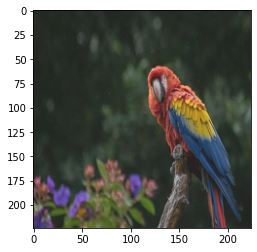

In [46]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=False,
                                            negative_only=True,
                                            num_features=5,
                                            hide_rest=False,
                                            min_weight=0.5)

plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(im_orig, mask), alpha=0.5)
plt.show()

### Explanation for the second highest prediction

The second highest predicion for this macaw is "lorikeet".

In [48]:
explanation.top_labels[1]   # class 90: lorikeet

90

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


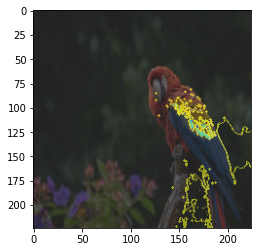

In [49]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[1],
                                            positive_only=True,
                                            num_features=5,
                                            hide_rest=True)

plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(temp, mask), alpha=0.5)
plt.show()

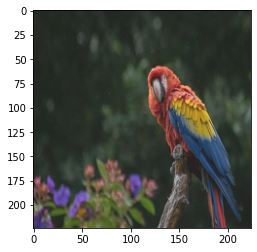

In [50]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=False,
                                            negative_only=True,
                                            num_features=5,
                                            hide_rest=False,
                                            min_weight=0.5)

plt.imshow(im_orig, alpha=0.75)
plt.imshow(mark_boundaries(im_orig, mask), alpha=0.5)
plt.show()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License